# Installing and Importing Libraries

In [22]:
%%capture
pip install pandas

In [17]:
%%capture
!pip install ffmpeg

In [18]:
%%capture
!pip install pydub

In [19]:
%%capture
!pip install jiwer

In [20]:
%%capture
!pip install wave

In [1]:
import pandas as pd

In [21]:
from pydub import AudioSegment
from IPython import display
from jiwer import wer
from wave import open as open_wave
import os

# Uploading Data

In [3]:
df_train = pd.read_csv('/work2/d1/cv-corpus-7.0-2021-07-21/ru/train.tsv', sep = '\t', header = 0)
df_test = pd.read_csv('/work2/d1/cv-corpus-7.0-2021-07-21/ru/test.tsv', sep = '\t', header = 0)
df_valid = pd.read_csv('/work2/d1/cv-corpus-7.0-2021-07-21/ru/validated.tsv', sep = '\t', header = 0)

In [8]:
df_train = df_train.drop(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'], axis = 1)
df_test = df_test.drop(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'], axis = 1)
df_valid = df_valid.drop(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'], axis = 1)

In [ ]:
# df_train['new_path'] = 0
# df_test['new_path'] = 0
# df_valid['new_path'] = 0

In [57]:
for i in range(len(df_train)):
    df_train.iloc[[i],[2]] = '/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/' + df_train.iloc[i][0]

In [50]:
for i in range(len(df_test)):
    df_test.iloc[[i],[2]] = '/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/' + df_test.iloc[i][0]

In [58]:
for i in range(len(df_valid)):
    df_valid.iloc[[i],[2]] = '/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/' + df_valid.iloc[i][0]

# Converting MP3 to WAV

In [59]:
df_train['new_file'] = 0
df_test['new_file'] = 0
df_valid['new_file'] = 0

In [61]:
from tqdm import tqdm

In [207]:
import wave      
def getWaveInfo(fname):       
    try:         
        w = wave.open(fname,'rb')         
        print("Number of channels is: ",    w.getnchannels())         
        print("Sample width in bytes is: ", w.getsampwidth())         
        print("Framerate is: ",             w.getframerate())         
        print("Number of frames is: ",      w.getnframes())     
    except:         
        print(w.error)

In [208]:
getWaveInfo("/work2/d1/wav_files/wav_train/0.wav")

Number of channels is:  1
Sample width in bytes is:  2
Framerate is:  16000
Number of frames is:  119808


In [64]:
for i in tqdm(range(len(df_train))):
    sound = AudioSegment.from_mp3(df_train.iloc[i][2])
    sound = sound.set_frame_rate(16000)
    sound.export(f"/work2/d1/wav_files/wav_train/{i}.wav", format="wav")
    df_train.iloc[[i], [3]] = f"/work2/d1/wav_files/wav_train/{i}.wav"

100%|██████████| 17070/17070 [25:38<00:00, 11.10it/s]


In [68]:
for i in tqdm(range(len(df_test))):
    sound = AudioSegment.from_mp3(df_test.iloc[i][2])
    sound = sound.set_frame_rate(16000)
    sound.export(f"/work2/d1/wav_files/wav_test/{i}.wav", format="wav")
    df_test.iloc[[i],[3]] = f"/work2/d1/wav_files/wav_test/{i}.wav"

100%|██████████| 8425/8425 [12:47<00:00, 10.98it/s]


In [74]:
df_valid_short = df_valid[:8400].copy()

In [75]:
for i in tqdm(range(len(df_valid_short))):
    sound = AudioSegment.from_mp3(df_valid_short.iloc[i][2])
    sound = sound.set_frame_rate(16000)
    sound.export(f"/work2/d1/wav_files/wav_valid/{i}.wav", format="wav")
    df_valid.iloc[[i],[3]] = f"/work2/d1/wav_files/wav_valid/{i}.wav"

100%|██████████| 8400/8400 [12:15<00:00, 11.43it/s]


# Adding Augmentation


https://github.com/makcedward/nlpaug/blob/master/example/audio_augmenter.ipynb

To perform audio augmentation I have tested several libraries to find the one which copes with the task best. The list of all available libraries can be found by following this link https://pythonrepo.com/repo/iver56-audiomentations-python-audio. My first choice was pydiogment which processes the audio, adds chosen effects, and saves it as a wav file. However, when tested and saved, there was a problem with file encryption and it couldn't have been played. Hence, I had to discard the library and look at other options. Also, when I looked closer at the list of available libraries pydiogment had only around 60 github stars, so I moved to the other library nlpaug with 2.8K github stars.

Nlpaug with MIT license can apply noise, pitch, shift, speed, mask, loudness, and other types of augmentation. When I tried to run the code, all worked well, but the augmented data from wav file was saved as ndarray. It wasn't exactly what I was looking for. So, I looked into other libraries to see if there is a straightforward way to augment wav file and get the output as wav file too.

I tested another library called pysndfx. It applied phaser and reverb directly to an audio file, then applied the effects to an ndarray, and stored the resulting audio as wav file to disk. However, when I played the audio file it was hard to understand what it was saying. So I concluded that this library would not be suitable for training STT coqui model.

Since nlpaug had the highest score on github, I decided to stick with it and find a way to convert ndarray, which was its output, to wav format. With the help of scipy.io.wavfile method write, I converted the augmented data to wav file and verified its quality. It seemed ok.

## Testing pydiogment

In [128]:
%%capture
pip install numpy

In [129]:
%%capture
pip install scipy

In [130]:
%%capture
pip install pydiogment

In [131]:
from pydiogment.auga import add_noise

In [132]:
test_file = "/work2/d1/wav_files/wav_valid/0.wav"
new_file = add_noise(test_file, 10)

Writing data to /work2/d1/wav_files/wav_valid/0_augmented_10_noisy.wav.


## Testing Nlpaug

In [106]:
%%capture
pip install nlpaug

In [133]:
import nlpaug
nlpaug.__version__

'1.1.7'

In [108]:
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer

In [110]:
%%capture
pip install librosa

In [112]:
pip install colorama

Note: you may need to restart the kernel to use updated packages.


In [111]:
import librosa
import librosa.display as librosa_display
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [113]:
file_path = "/work2/d1/wav_files/wav_valid/0.wav"
data, sr = librosa.load(file_path)

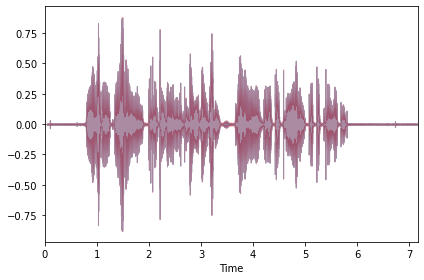

In [115]:
aug = naa.NoiseAug()
augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.5)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

In [174]:
augmented_data

array([ 6.5291189e-08,  1.4205384e-07, -2.5078168e-07, ...,
       -6.6510183e-12,  6.1096887e-12,  0.0000000e+00], dtype=float32)

## Augmentation
(wrong format float32)

In [171]:
import numpy as np

In [175]:
from scipy.io.wavfile import write

In [178]:
def float2pcm(sig, dtype='int16'): 
    sig = np.asarray(sig) 
    dtype = np.dtype(dtype)
    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

In [179]:
my_test = float2pcm(augmented_data)

In [181]:
np.max(my_test)

3173

In [182]:
write('/work2/d1/wav_files/wav_valid/0_test.wav', 16000, my_test)

In [134]:
df_train['wav_filename'] = 0
df_test['wav_filename'] = 0
df_valid_short['wav_filename'] = 0

In [187]:
import wave

In [ ]:
aug = naa.NoiseAug()

In [190]:
import pyaudio

In [139]:
for i in tqdm(range(len(df_train))):
    file_path = df_train.iloc[i][3]
    data, sr = librosa.load(file_path)
    augmented_data = aug.augment(data)
    write(f'/work2/d1/wav_files/aug_train/{i}.wav', 16000, augmented_data)
    df_train.iloc[[i], [5]] = f'/work2/d1/wav_files/aug_train/{i}.wav'

100%|██████████| 17070/17070 [26:55<00:00, 10.57it/s]


In [188]:
CHUNK = 10
def play_wav(fname, chunk=CHUNK):
    # create an audio object
    wf = wave.open(fname, 'rb')
    p = pyaudio.PyAudio()

    # open stream based on the wave object which has been input.
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    # read data (based on the chunk size)
    data = wf.readframes(chunk)

    # play stream (looping from beginning of file to the end)
    while len(data) > 0:
        # writing to the stream is what *actually* plays the sound.
        stream.write(data)
        data = wf.readframes(chunk)

    # cleanup stuff
    stream.close()
    p.terminate()

In [191]:
play_wav(fname = '/work2/d1/wav_files/wav_valid/0_test.wav')

In [141]:
for i in tqdm(range(len(df_test))):
    file_path = df_test.iloc[i][3]
    data, sr = librosa.load(file_path)
    augmented_data = aug.augment(data)
    write(f'/work2/d1/wav_files/aug_test/{i}.wav', 16000, augmented_data)
    df_test.iloc[[i], [5]] = f'/work2/d1/wav_files/aug_test/{i}.wav'

100%|██████████| 8425/8425 [13:50<00:00, 10.14it/s]


In [142]:
for i in tqdm(range(len(df_valid_short))):
    file_path = df_valid_short.iloc[i][3]
    data, sr = librosa.load(file_path)
    augmented_data = aug.augment(data)
    write(f'/work2/d1/wav_files/aug_valid/{i}.wav', 16000, augmented_data)
    df_valid_short.iloc[[i], [5]] = f'/work2/d1/wav_files/aug_valid/{i}.wav'

100%|██████████| 8400/8400 [12:54<00:00, 10.84it/s]


## Testing pysndfx

In [126]:
%%capture
pip install pysndfx

In [118]:
from pysndfx import AudioEffectsChain

fx = (
    AudioEffectsChain()
    .highshelf()
    .reverb()
    .phaser()
    .delay()
    .lowshelf()
)

In [120]:
infile = '/work2/d1/wav_files/wav_valid/0.wav'
outfile = '/work2/d1/wav_files/wav_valid/0_processed.wav'


# Apply phaser and reverb directly to an audio file.
fx(infile, outfile)

# Or, apply the effects directly to a ndarray.
from librosa import load
y, sr = load(infile, sr=None)
y = fx(y)

# Apply the effects and return the results as a ndarray.
x = fx(infile)

# Apply the effects to a ndarray but store the resulting audio to disk.
fx(x, outfile)

In [123]:
outfile2 = '/work2/d1/wav_files/wav_valid/0_processed2.wav'
fx(augmented_data, outfile2)

# Saving File Size

In [81]:
df_train['wav_filesize'] = 0
df_test['wav_filesize'] = 0
df_valid_short['wav_filesize'] = 0

In [195]:
for i in tqdm(range(len(df_train))):
    df_train.iloc[[i],[4]] = os.path.getsize(df_train.iloc[i][3])

100%|██████████| 17070/17070 [00:04<00:00, 3475.24it/s]


In [196]:
for i in tqdm(range(len(df_test))):
    df_test.iloc[[i],[4]] = os.path.getsize(df_test.iloc[i][3])

100%|██████████| 8425/8425 [00:02<00:00, 3522.46it/s]


In [197]:
for i in tqdm(range(len(df_valid_short))):
    df_valid_short.iloc[[i],[4]] = os.path.getsize(df_valid_short.iloc[i][3])

100%|██████████| 8400/8400 [00:02<00:00, 3491.29it/s]


In [198]:
df_train.head()

,path,sentence,new_path,new_file,wav_filesize,wav_filename
0,common_voice_ru_21949650.mp3,Теперь слово предоставляется Генеральному секр...,/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/co...,/work2/d1/wav_files/wav_train/0.wav,239660,/work2/d1/wav_files/aug_train/0.wav
1,common_voice_ru_21949651.mp3,"В португальском языке такие слова, как жизнь, ...",/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/co...,/work2/d1/wav_files/wav_train/1.wav,210476,/work2/d1/wav_files/aug_train/1.wav
2,common_voice_ru_21949693.mp3,За прошедший год значительно продвинулось суде...,/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/co...,/work2/d1/wav_files/wav_train/2.wav,192044,/work2/d1/wav_files/aug_train/2.wav
3,common_voice_ru_21949699.mp3,Я предоставляю слово наблюдателю от Святого Пр...,/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/co...,/work2/d1/wav_files/wav_train/3.wav,210476,/work2/d1/wav_files/aug_train/3.wav
4,common_voice_ru_21949704.mp3,Швейцария стала одним из ее авторов.,/work2/d1/cv-corpus-7.0-2021-07-21/ru/clips/co...,/work2/d1/wav_files/wav_train/4.wav,125228,/work2/d1/wav_files/aug_train/4.wav


# Preprocessing Text

In [245]:
import re

def text_cleaning(text):
    
    # changing to lower register
    text = text.lower()
    
    # removing punctuation and keeping only cyrillic letters
    reg = re.compile('[^а-яё ]')
    text = reg.sub('', text)
    
    return text

In [246]:
df_train['sentence_clean'] = df_train['sentence'].apply(text_cleaning)
df_test['sentence_clean'] = df_test['sentence'].apply(text_cleaning)
df_valid_short['sentence_clean'] = df_valid_short['sentence'].apply(text_cleaning)

# Saving to CSV

In [247]:
data_train = df_train[['new_file', 'wav_filesize', 'sentence_clean']][:2000].copy()
data_test = df_test[['new_file', 'wav_filesize', 'sentence_clean']][:700].copy()
data_valid = df_valid_short[['new_file', 'wav_filesize', 'sentence_clean']][:700].copy()

In [248]:
data_train.rename(columns={'new_file': 'wav_filename', 'sentence_clean': 'transcript'}, inplace=True)
data_test.rename(columns={'new_file': 'wav_filename', 'sentence_clean': 'transcript'}, inplace=True)
data_valid.rename(columns={'new_file': 'wav_filename', 'sentence_clean': 'transcript'}, inplace=True)

In [253]:
data_valid[175:179]

,wav_filename,wav_filesize,transcript
175,/work2/d1/wav_files/wav_valid/175.wav,213548,не заставляй меня выбирать между джимми и тобой
176,/work2/d1/wav_files/wav_valid/176.wav,73772,да
177,/work2/d1/wav_files/wav_valid/177.wav,77612,
178,/work2/d1/wav_files/wav_valid/178.wav,165932,необходимо повысить уровень ответственности и ...


In [259]:
data_valid[data_valid['transcript'] == ''].index

Int64Index([177, 352, 491], dtype='int64')

In [262]:
data_test[data_test['transcript'] == ''].index

Int64Index([175], dtype='int64')

In [263]:
data_train[data_train['transcript'] == ''].index

Int64Index([], dtype='int64')

In [261]:
data_valid.drop([177, 352, 491], inplace = True)

In [264]:
data_test.drop([175], inplace = True)

In [265]:
data_train.to_csv('/work2/d1/train.csv')
data_test.to_csv('/work2/d1/test.csv')
data_valid.to_csv('/work2/d1/dev.csv')